In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from data_provider.data_factory import data_provider
from exp.exp_basic import Exp_Basic
from utils.tools import EarlyStopping, adjust_learning_rate
from utils.metrics import metric
import torch
import torch.nn as nn
from torch import optim
import os
import time
import warnings
import numpy as np
import json

warnings.filterwarnings('ignore')


class Exp_Long_Term_Forecast(Exp_Basic):
    def __init__(self, args):
        super(Exp_Long_Term_Forecast, self).__init__(args)

    def _build_model(self):
        model = self.model_dict[self.args.model].Model(self.args).float()

        if self.args.use_multi_gpu and self.args.use_gpu:
            model = nn.DataParallel(model, device_ids=self.args.device_ids)
        return model

    def _get_data(self, flag):
        data_set, data_loader = data_provider(self.args, flag)
        return data_set, data_loader

    def _select_optimizer(self):
        model_optim = optim.Adam(self.model.parameters(), lr=self.args.learning_rate)
        return model_optim

    def _select_criterion(self):
        if self.args.loss.lower() == 'mse':
            criterion = nn.MSELoss()
        elif self.args.loss.lower() == 'mae':
            criterion = nn.L1Loss()
        return criterion

    def vali(self, vali_data, vali_loader, criterion):
        total_loss = []
        self.model.eval()
        with torch.no_grad():
            preds, trues = [], []
            for i, (batch_x, batch_y) in enumerate(vali_loader):
                batch_x = batch_x.float().to(self.device, non_blocking=True)
                batch_y = batch_y[:, -self.args.pred_len:, :].float()
                if self.args.use_amp:
                    with torch.cuda.amp.autocast():
                        outputs = self.model(batch_x)
                else:
                    outputs = self.model(batch_x)
                preds.append(outputs.detach().cpu().numpy())
                trues.append(batch_y.detach().cpu().numpy())

        preds = np.concatenate(preds, axis=0)
        trues = np.concatenate(trues, axis=0)

        # Reverse the log transform
        preds_exp = np.exp(preds)
        trues_exp = np.exp(trues).squeeze(-1)

        target_idx = getattr(vali_data, 'target_col_index', 0)
        # Compute metrics on original scale
        print("preds_exp shape:", preds_exp.shape)
        print("trues_exp shape:", trues_exp.shape)
        print("Number of dims (preds):", preds_exp.ndim)
        print("Number of dims (trues):", trues_exp.ndim)

        print("target_idx:", target_idx)
        # Show the valid range for axis 2
        print("Valid target indices for axis 2:", list(range(preds_exp.shape[2])))


        mae, mse, rmse, mape, mspe = metric(preds_exp[:, :, target_idx], trues_exp)
        # mse, mae = metric(preds_exp[:, :, target_idx], trues_exp[:, :, target_idx])
        vali_loss = mae if self.args.loss.lower() == 'mae' else mse

        self.model.train()
        torch.cuda.empty_cache()
        return vali_loss

    def train(self, setting):
        train_data, train_loader = self._get_data(flag='train')
        vali_data, vali_loader = self._get_data(flag='val')
        test_data, test_loader = self._get_data(flag='test')
        print('target column index',train_data.target_col_index)
        path = os.path.join(self.args.checkpoints, setting)
        os.makedirs(path, exist_ok=True)

        train_steps = len(train_loader)
        early_stopping = EarlyStopping(patience=self.args.patience, verbose=True)

        model_optim = self._select_optimizer()
        criterion = self._select_criterion()

        if self.args.use_amp:
            scaler = torch.cuda.amp.GradScaler()
        # for epoch in range(self.args.train_epochs):
        #             train_loss = []
        #             self.model.train()
        #             epoch_time = time.time()
        #             for i, (batch_x, batch_y) in enumerate(train_loader):
        #                 model_optim.zero_grad(set_to_none=True)
        #                 batch_x = batch_x.float().to(self.device, non_blocking=True)
        #                 batch_y = batch_y[:, -self.args.pred_len:, :].float().to(self.device, non_blocking=True)
        #                 if self.args.use_amp:
        #                     with torch.cuda.amp.autocast():
        #                         outputs = self.model(batch_x)
        #                         print('outputs before loss calculation',outputs.shape)
        #                         loss = criterion(outputs, batch_y)

        for epoch in range(self.args.train_epochs):
            train_loss = []
            self.model.train()
            epoch_time = time.time()
            for i, (batch_x, batch_y) in enumerate(train_loader):
                model_optim.zero_grad(set_to_none=True)
                batch_x = batch_x.float().to(self.device)
                batch_y = batch_y[:, -self.args.pred_len:, :].float().to(self.device).squeeze(-1)

                if self.args.use_amp:
                    with torch.cuda.amp.autocast():
                        outputs = self.model(batch_x)
                else:
                    outputs = self.model(batch_x)

                # —— new: slice to target channel only ——
                t_idx  = train_data.target_col_index  # or self.args.target_col_index
                pred_t = outputs[:, :, t_idx]         # shape (B, pred_len)
                # true_t = batch_y[:, :, t_idx].squeeze(-1)
                loss   = criterion(pred_t, batch_y)

                train_loss.append(loss.item())
                if self.args.use_amp:
                    scaler.scale(loss).backward()
                    scaler.step(model_optim)
                    scaler.update()
                else:
                    loss.backward()
                    model_optim.step()
                torch.cuda.empty_cache()

            print(f"Epoch: {epoch+1} cost time: {time.time()-epoch_time:.2f}s")
            train_loss = np.average(train_loss)
            vali_loss = self.vali(vali_data, vali_loader, self.args.loss)
            test_loss = self.vali(test_data, test_loader, self.args.loss)

            print(f"Epoch: {epoch+1}, Steps: {train_steps} | Train Loss: {train_loss:.3f}  vali_loss: {vali_loss:.3f}   test_loss: {test_loss:.3f}")
            early_stopping(vali_loss, self.model, path)
            if early_stopping.early_stop:
                print("Early stopping")
                break

            adjust_learning_rate(model_optim, epoch + 1, self.args)
        torch.cuda.empty_cache()

    def test(self, setting, test=1):
        test_data, test_loader = self._get_data(flag='test')
        logged_cols = test_data.logged_cols
        path = os.path.join(self.args.checkpoints, setting)
        if test:
            print('loading model')
            self.model.load_state_dict(torch.load(os.path.join(path, 'checkpoint.pth')))

        dict_path = os.path.join('./test_dict', f'{self.args.model}_Sent')
        os.makedirs(dict_path, exist_ok=True)

        self.model.eval()
        with torch.no_grad():
            preds, trues = [], []
            for i, (batch_x, batch_y) in enumerate(test_loader):
                batch_x = batch_x.float().to(self.device, non_blocking=True)
                batch_y = batch_y[:, -self.args.pred_len:, :].float()
                if self.args.use_amp:
                    with torch.cuda.amp.autocast():
                        outputs = self.model(batch_x)
                else:
                    outputs = self.model(batch_x)
                print('test outputs', outputs.shape)
                preds.append(outputs.detach().cpu().numpy())
                trues.append(batch_y.detach().cpu().numpy())

        preds = np.concatenate(preds, axis=0)
        trues = np.concatenate(trues, axis=0)


        # --- Optional inverse scaling ---
        if hasattr(test_data, 'inverse_transform') and hasattr(test_data, 'scaler'):
            print('inverse scaling in test')
            # try:
            print('true shape:', trues.shape, 'preds shape', preds.shape)
            preds_orig = test_data.inverse_transform(torch.from_numpy(preds)).numpy()
            trues_orig = test_data.inverse_transform(torch.from_numpy(trues)).numpy()
            # except Exception as e:
            #     print(f"WARNING: Inverse transform failed: {e}. Using exponentiated data.")
        # --- Reverse log on predictions and truths ---
        print('true shape 2:', trues_orig.shape, 'preds shape 2:', preds_orig.shape)
        preds_orig = np.exp(preds_orig)
        trues_orig = np.exp(trues_orig)

        # Metrics on original scale
        t_idx = getattr(test_data, 'target_col_index', 0)
        pred_t = preds_orig[:, :, 0]     # shape (N, pred_len)
        true_t = trues_orig[:, :, 0]     # shape (N, pred_len)
        mae, mse, rmse, mape, mspe = metric(pred_t, true_t)
        print(f'Metrics (Original Scale: channel={0}):  mse:{mse}, rmse:{rmse}, mae:{mae}, mspe:{mspe}, mape:{mape}')
        # print(f'Metrics (Original Scale): mse: {mse:.3f}  mae: {mae:.3f}')

        # Save metrics and arrays
        with open(os.path.join(dict_path, 'records.json'), 'w') as f:
            json.dump({'mse': f"{mse:.3f}", 'mae': f"{mae:.3f}"}, f)
        # np.save(os.path.join(dict_path, 'pred.npy'), preds_orig)
        # np.save(os.path.join(dict_path, 'true.npy'), trues_orig)
        np.save(os.path.join(dict_path, f'pred_ch{0}.npy'), pred_t)
        np.save(os.path.join(dict_path, f'true_ch{0}.npy'), true_t)

        # --- Plot Full Test Set ---
        fig = None
        try:
            full_y = test_data.data_y[:, t_idx]          # all time steps
            if test_data.scale:
                # inverse‐scale only that feature
                dummy = np.zeros((len(full_y), test_data.scaler.n_features_in_))
                dummy[:, t_idx] = full_y
                full_y = test_data.scaler.inverse_transform(dummy)[:, t_idx]
            full_y = np.exp(full_y)

            # align it with first‐step predictions
            pred_first = pred_t[:, 0]  # (N,)
            full_y = full_y[self.args.seq_len : self.args.seq_len + len(pred_first)]

            import matplotlib.pyplot as plt
            fig = plt.figure(figsize=(15, 6))
            # plt.plot(np.arange(len(truth_series)), truth_series, label=f'Ground Truth ({self.args.target})')
            plt.plot(np.arange(len(full_y)), full_y, label=f'Ground Truth ({self.args.target})')
            plt.plot(np.arange(len(pred_first)), pred_first, label='Prediction (1st Step)', alpha=0.7)
            plt.title(f'Test Set: Ground Truth vs. First-Step Prediction ({self.args.target})')
            plt.xlabel('Time Step Index')
            plt.ylabel('Original Value')
            plt.legend()
            plt.grid(True)
            save_path = os.path.join(dict_path, 'test_set_truth_vs_pred_original_scale.png')
            plt.savefig(save_path)
            print(f'Plot saved to {save_path}')
        except Exception as e:
            print(f"Plotting failed: {e}")

        torch.cuda.empty_cache()
        return fig


c:\Users\Hiroshi\miniconda3\envs\leddam\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Starting run: aapl_leddam_notebook
Use GPU: cuda:0
>>>>>>>start training : Vanilla_AAPL_xlstm_date_pl48_n_layers_3_d_model_256_dropout_0.0_pe_type_no_bs_64_lr_0.0001>>>>>>>>>>>>>>>>>>>>>>>>>>
train set size: 865
val set size: 74
test set size: 73
target column index 3
Epoch: 1 cost time: 3.65s
preds_exp shape: (64, 48, 5)
trues_exp shape: (64, 48)
Number of dims (preds): 3
Number of dims (trues): 2
target_idx: 3
Valid target indices for axis 2: [0, 1, 2, 3, 4]
preds_exp shape: (73, 48, 5)
trues_exp shape: (73, 48)
Number of dims (preds): 3
Number of dims (trues): 2
target_idx: 3
Valid target indices for axis 2: [0, 1, 2, 3, 4]
Epoch: 1, Steps: 13 | Train Loss: 0.195  vali_loss: 2.003   test_loss: 2.631
Validation loss decreased (inf --> 2.003472).  Saving model ...
Updating learning rate to 0.0001
Epoch: 2 cost time: 0.61s
preds_exp shape: (64, 48, 5)
trues_exp shape: (64, 48)
Number of dims (preds): 3
Number of dims (trues): 2
target_idx: 3
Valid target indices for axis 2: [0, 1, 2, 3

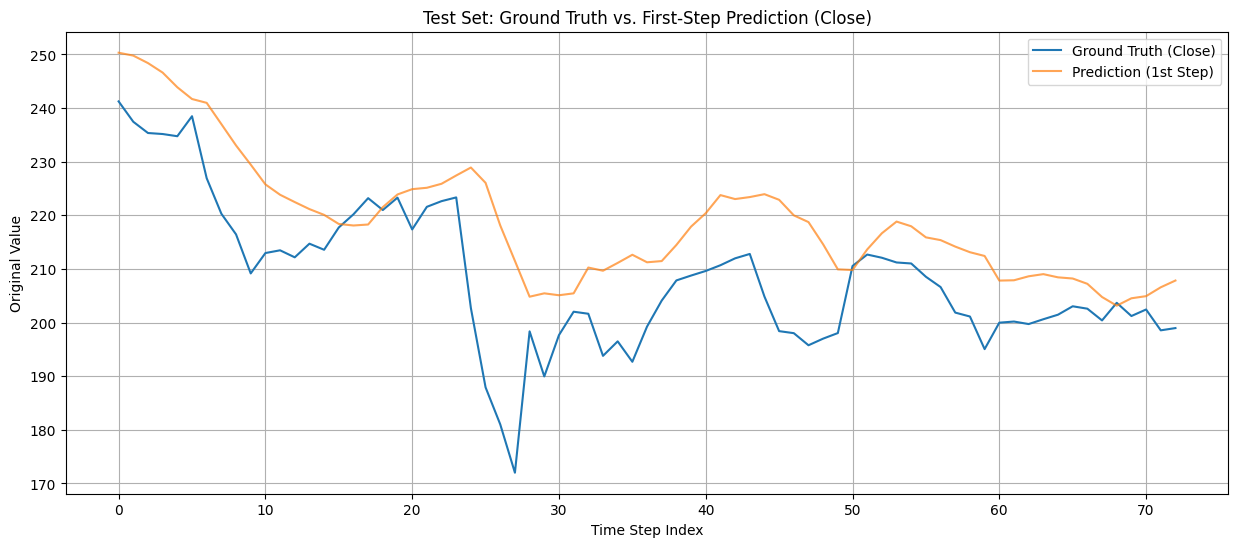

Run finished.


In [3]:
# --- Imports ---
import argparse
import os
import torch
# Make sure this import is correct
# from exp.exp_long_term_forecasting import Exp_Long_Term_Forecast
import random
import numpy as np

# --- Train Function ---
# Assume the 'train(ii, args)' function definition from your run.py is accessible here
# (either defined above in the notebook or imported e.g., from run import train)
def train(ii,args):
    setting = 'Vanilla_{}_pl{}_n_layers_{}_d_model_{}_dropout_{}_pe_type_{}_bs_{}_lr_{}'.format(
                    args.data_path[:-4], args.pred_len, args.n_layers, args.d_model,
                    args.dropout, args.pe_type, args.batch_size, args.learning_rate)

    # This line inside train needs the variable 'Exp' to be defined in the scope it's called from
    exp = Exp(args) # 'Exp' MUST be defined before train() is called

    print(f'>>>>>>>start training : {setting}>>>>>>>>>>>>>>>>>>>>>>>>>>')
    exp.train(setting)
    print(f'>>>>>>>testing : {setting}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<')
    fig = exp.test(setting,test=1)
    torch.cuda.empty_cache()
    return fig

# --- Configuration ---
fix_seed = 2021
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

args = argparse.Namespace(
    # --- Your arguments dictionary here ---
    root_path='./datasets/',
    data_path='AAPL_xlstm_date.csv',
    model_id='aapl_leddam_notebook',
    technical_indicators=False,
    rolling_window=5,
    model='Leddam',
    features='MS',
    target='Close',
    freq='d',
    checkpoints='./checkpoints',
    seq_len=48,
    label_len=24,
    pred_len=48,
    enc_in=5,
    dec_in=5,
    d_model=256,
    n_layers=3,
    kernel_size=25,
    pe_type='no',
    dropout=0.0,
    revin=True,
    num_workers=0,
    itr=1,
    train_epochs=100,
    batch_size=64,
    patience=6,
    learning_rate=0.0001,
    des='Notebook_Run',
    loss='mse',
    lradj='type1',
    use_amp=True,
    use_gpu=True,
    gpu=0,
    use_multi_gpu=False,
    devices='0,1,2,3'
)

# --- Setup ---
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False
if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ', '')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

args.label_len = int(args.seq_len // 2)

# --- !!! ADD THIS LINE !!! ---
# Assign the imported class to the variable name 'Exp'
# This makes it available globally for the 'train' function to use
Exp = Exp_Long_Term_Forecast
# -----------------------------

# --- Execute ---
print(f"Starting run: {args.model_id}")
fig = train(1, args) # Now 'train' can find the global variable 'Exp'
display(fig)
print("Run finished.")

Metrics (Original Scale: channel=0):  mse:535.800537109375, rmse:23.14736557006836, mae:18.481666564941406, mspe:0.013641657307744026, mape:0.09167879074811935


In [4]:
# import argparse
# import os
# import torch
# from exp.exp_long_term_forecasting import Exp_Long_Term_Forecast
# import random
# import numpy as np
# def train(ii,args):
#     setting = '{}_pl{}_n_layers_{}_d_model_{}_dropout_{}_pe_type_{}_bs_{}_lr_{}'.format(
#                     args.data_path[:-4],
#                     args.pred_len,
#                     args.n_layers,
#                     args.d_model,
#                     args.dropout,
#                     args.pe_type,
#                     args.batch_size,
#                     args.learning_rate,
#                     )

#     exp = Exp(args)  # set experiments
#     print(f'>>>>>>>start training : {setting}>>>>>>>>>>>>>>>>>>>>>>>>>>')
#     exp.train(setting)
#     print(f'>>>>>>>testing : {setting}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<')
#     exp.test(setting,test=1)
#     torch.cuda.empty_cache()
    
# if __name__ == '__main__':
#     fix_seed = 2021
#     random.seed(fix_seed)
#     torch.manual_seed(fix_seed)
#     np.random.seed(fix_seed)

#     parser = argparse.ArgumentParser(description='Leddam')

#     # basic config
    
#     parser.add_argument('--kernel_size', type=int, default=25, help='kernel_size hyperparameter of smoothing')
    
#     # parser.add_argument('--task_name', type=str, required=True, default='aapl_vanilla')
#     # parser.add_argument('--is_training', type=int, required=True, default=1, help='status')
#     parser.add_argument('--model_id', type=str, required=False, default='aapl_vanilla', help='model id')
#     parser.add_argument('--model', type=str, default='Leddam')
#     # data loader
#     # parser.add_argument('--data', type=str, required=True, default='ETTm1', help='dataset type')
#     parser.add_argument('--root_path', type=str, default='./datasets/', help='root path of the data file')
#     parser.add_argument('--data_path', type=str, default='AAPL_xlstm_date.csv', help='data file')
#     # parser.add_argument('--features', type=str, default='M',
#                         # help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')
#     parser.add_argument('--target', type=str, default='Close', help='target feature in S or MS task')
#     # parser.add_argument('--freq', type=str, default='h', help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
#     parser.add_argument('--checkpoints', type=str, default='./checkpoints', help='location of model checkpoints')

#     # forecasting task
#     parser.add_argument('--seq_len', type=int, default=96, help='input sequence length of backbone model')
#     parser.add_argument('--label_len', type=int, default=48, help='start token length')
#     parser.add_argument('--pred_len', type=int, default=96, help='prediction sequence length')


#     # model define
#     parser.add_argument('--enc_in', type=int, default=7, help='encoder input size')
#     parser.add_argument('--d_model', type=int, default=256, help='model input size')
#     parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')
#     parser.add_argument('--c_out', type=int, default=7, help='output size')
#     parser.add_argument('--n_layers', type=int, default=3, help='n_layers of DEFT Block')
#     parser.add_argument('--pe_type', type=str, default='no', help='position embedding type')
#     parser.add_argument('--dropout', type=float, default=0., help='dropout ratio')
#     parser.add_argument('--revin', type=bool, default=True, help='using revin from non-stationary transformer')


#     # optimization
#     parser.add_argument('--num_workers', type=int, default=0, help='data loader num workers')
#     parser.add_argument('--itr', type=int, default=1, help='experiments times')
#     parser.add_argument('--train_epochs', type=int, default=100, help='train epochs')
#     parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')
#     parser.add_argument('--patience', type=int, default=6, help='early stopping patience')
#     parser.add_argument('--learning_rate', type=float, default=1e-4, help='optimizer learning rate')
#     parser.add_argument('--des', type=str, default='test', help='exp description')
#     parser.add_argument('--loss', type=str, default='mse', help='loss function')
#     parser.add_argument('--lradj', type=str, default='constant', help='adjust learning rate')
#     parser.add_argument('--use_amp', type=bool, default=True, help='use automatic mixed precision training')
#     # GPU
#     parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
#     parser.add_argument('--gpu', type=int, default=0, help='gpu')
#     parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
#     parser.add_argument('--devices', type=str, default='0,1,2,3', help='device ids of multile gpus')


#     args = parser.parse_args()
#     args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False
#     if args.use_gpu and args.use_multi_gpu:
#         args.devices = args.devices.replace(' ', '')
#         device_ids = args.devices.split(',')
#         args.device_ids = [int(id_) for id_ in device_ids]
#         args.gpu = args.device_ids[0]
        
#     args.label_len=int(args.seq_len//2)
#     Exp = Exp_Long_Term_Forecast

    
#     print('Args in experiment:')
#     print(args)
#     train(1,args) 
